## Prompt 1

/ask there are 2 jpg files in ./image directory. "./image/img_left.jpg" and "./image/img_right.jpg". 
I would like to use OpenCV in C# interactive in a jupyter notebook with .NET kernel to identify features in both images using SIFT and then matching them and displaying the matches on the jupyter cell. 

The code should do:
 - Load the images "./image/img_left.jpg" and "./image/img_right.jpg"
 - extract SIFT features and matchthem
 - Use RANSAC to reduce outliners.
 - This is .net interactive so we need to install and reference packages with #r instead of nuget add package
 - Use OpenCVSharp version 4.7.0.20230115
 - Use SkiaSharp version 1.68.1
 - Use Jellyfin.SkiaSharp.NativeAssets.LinuxArm version 1.68.1
 - Make sure you have correct namespaces imported with usings at the top.
 - Add the package references to a seperate cell.
 - Make sure to use SKImage to display the final bitmap in jupyter without any complicated code.

The code is running inside an ARM 64 Linux container however, I have manually built runtime libraries so I do not need the runtime packages intalled.

There are some imitations as following:
- Please remeber as this is in Jupyter, I cannot use cv2 image show.
- We cannot use using statements to dispose disposables in this version of .NET interactive.
- Do not add package for OpenCVSharl runtime dependencies.




Installed Packages Jellyfin.SkiaSharp.NativeAssets.LinuxArm, 1.68.1 OpenCvSharp4, 4.7.0.20230115 SkiaSharp, 1.68.1


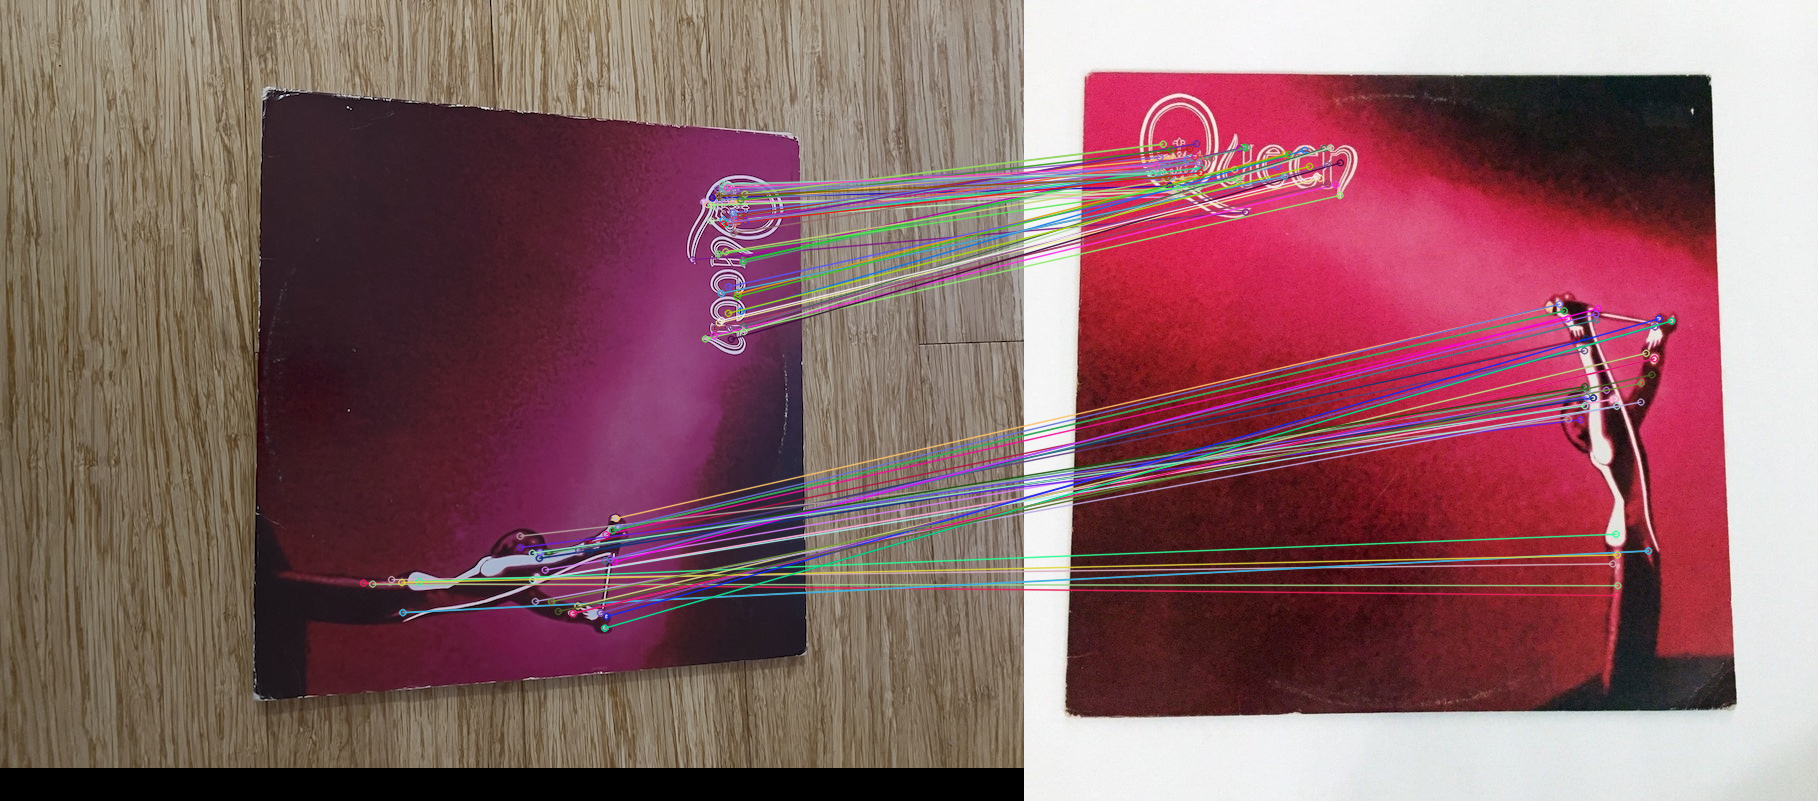

In [3]:
#r "nuget: OpenCvSharp4, 4.7.0.20230115"
#r "nuget: SkiaSharp, 1.68.1"
#r "nuget: Jellyfin.SkiaSharp.NativeAssets.LinuxArm, 1.68.1"

using System;
using System.IO;
using System.Linq;
using OpenCvSharp;
using SkiaSharp;
using Microsoft.DotNet.Interactive.Formatting;
using OpenCvSharp.Features2D;

// Load images
var imgLeft = Cv2.ImRead("./image/img_left.jpg", ImreadModes.Color);
var imgRight = Cv2.ImRead("./image/img_right.jpg", ImreadModes.Color);

if (imgLeft.Empty() || imgRight.Empty())
{
    throw new Exception("One or both images failed to load.");
}

// Convert to grayscale
Mat grayLeft = new Mat(), grayRight = new Mat();
Cv2.CvtColor(imgLeft, grayLeft, ColorConversionCodes.BGR2GRAY);
Cv2.CvtColor(imgRight, grayRight, ColorConversionCodes.BGR2GRAY);

// Create SIFT detector
var sift = SIFT.Create();  // FIXED

// Detect and compute features
KeyPoint[] keypointsLeft, keypointsRight;
Mat descriptorsLeft = new Mat(), descriptorsRight = new Mat();
sift.DetectAndCompute(grayLeft, null, out keypointsLeft, descriptorsLeft);
sift.DetectAndCompute(grayRight, null, out keypointsRight, descriptorsRight);

// Match features using BFMatcher
var bfMatcher = new BFMatcher(NormTypes.L2, crossCheck: true);  // FIXED
var matches = bfMatcher.Match(descriptorsLeft, descriptorsRight);

// Sort matches by distance
Array.Sort(matches, (m, n) => m.Distance.CompareTo(n.Distance));

// Extract matched keypoints as Point2f
var srcPoints = matches.Select(m => keypointsLeft[m.QueryIdx].Pt).ToArray();
var dstPoints = matches.Select(m => keypointsRight[m.TrainIdx].Pt).ToArray();

// Convert to OpenCV Mat
Mat srcMat = new Mat(srcPoints.Length, 1, MatType.CV_32FC2, srcPoints);
Mat dstMat = new Mat(dstPoints.Length, 1, MatType.CV_32FC2, dstPoints);

// Use RANSAC to filter out outliers
var mask = new Mat();
var homography = Cv2.FindHomography(srcMat, dstMat, HomographyMethods.Ransac, 3, mask);

// Filter inlier matches
var inlierMatches = matches.Where((m, i) => mask.At<byte>(i) > 0).ToArray();

// Draw matches with inliers
Mat matchedImage = new Mat();
Cv2.DrawMatches(imgLeft, keypointsLeft, imgRight, keypointsRight, inlierMatches, matchedImage, flags: DrawMatchesFlags.NotDrawSinglePoints);

// Convert Mat to SKBitmap
var ms = new MemoryStream(matchedImage.ToBytes(".png"));  // FIXED: Ensure `ToBytes` succeeds.
SKBitmap bitmap = SKBitmap.Decode(ms);

// Display in Jupyter Notebook
Formatter.Register<SKBitmap>((bmp, writer) =>
{
    using var image = SKImage.FromBitmap(bmp);
    using var data = image.Encode(SKEncodedImageFormat.Png, 100);
    var base64 = Convert.ToBase64String(data.ToArray());
    writer.Write($"<img src='data:image/png;base64,{base64}' />");
}, "text/html");

bitmap // This will display the image inside Jupyter Notebook
